# Fitting line profiles with lorentzian and Gausian

In [1]:
import sys
sys.path.append('D:/solar flares/data/2017-09-06')
import use_nessi3 as un
import data_analysis as da
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
import os
from importlib import reload
# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d
from voight_fit import *

In [2]:
sys.path

['d:\\solar flares\\data\\voigth_fitting',
 'c:\\Users\\Gebruiker\\Anaconda3\\python311.zip',
 'c:\\Users\\Gebruiker\\Anaconda3\\DLLs',
 'c:\\Users\\Gebruiker\\Anaconda3\\Lib',
 'c:\\Users\\Gebruiker\\Anaconda3',
 '',
 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages',
 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\win32',
 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\Pythonwin',
 'D:/solar flares/data/2017-09-06',
 'D:/solar flares/data/2017-09-06']

no time correction factor added.
the correction factor is 0.25544433378225306
param_fit[-1] = (array([1.77561913e-01, 6.56303503e+03, 4.66127895e-01, 3.53400604e-04]), array([1.03115245e-01, 2.77681536e-02, 3.13002114e-02, 7.00063896e+02])). Here comes the plot:


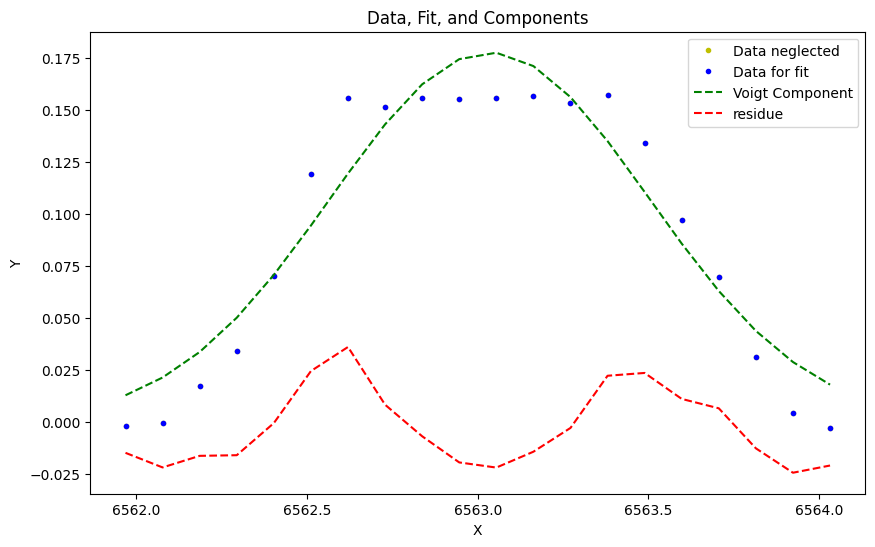

param_fit[-1] = (array([1.75847515e-01, 6.56302696e+03, 4.74902208e-01, 5.28413071e-04]), array([4.28616095e+00, 2.61440878e-02, 2.68838511e-02, 5.21064052e+03])). Here comes the plot:


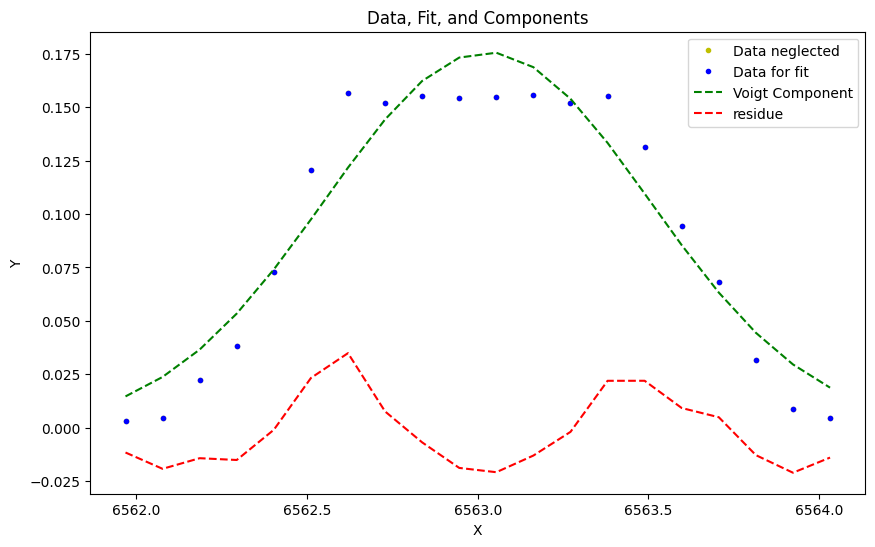

param_fit[-1] = (array([1.81733526e-01, 6.56301877e+03, 4.79952504e-01, 6.39580332e-04]), array([3.15040043e-01, 2.49530540e-02, 2.61226386e-02, 1.05980865e+03])). Here comes the plot:


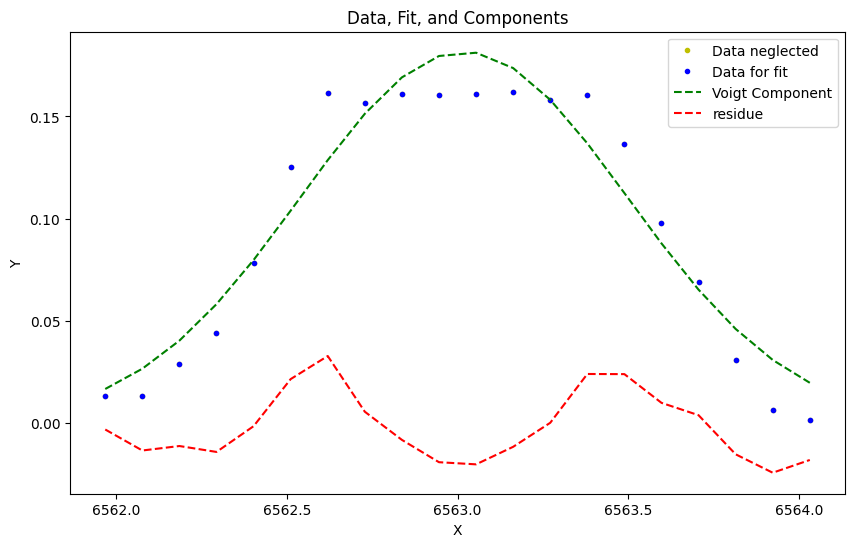

param_fit[-1] = (array([1.90729251e-01, 6.56301969e+03, 4.81396475e-01, 1.16264981e-03]), array([8.77080629e+00, 2.46035262e-02, 2.51370531e-02, 6.85623855e+03])). Here comes the plot:


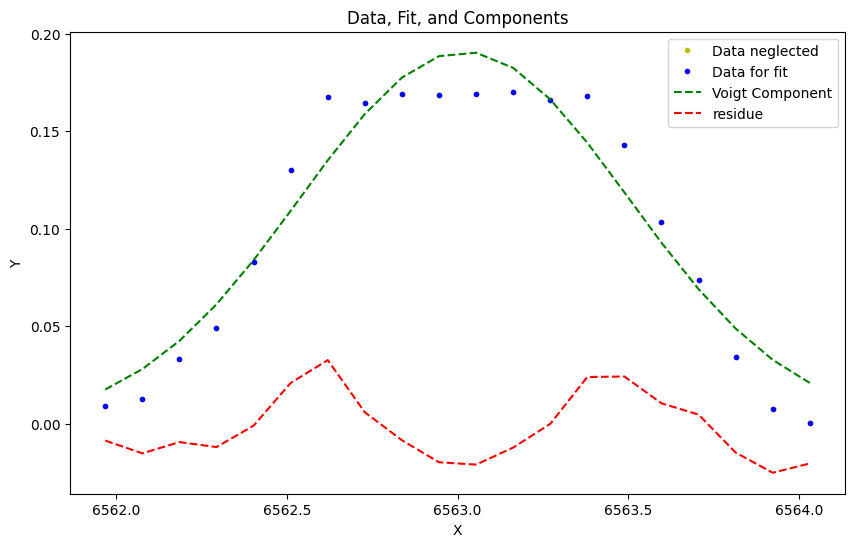

param_fit[-1] = (array([ 2.03534717e-01,  6.56300833e+03,  4.76150539e-01, -2.40517022e-04]), array([8.27558916e-01, 2.63687704e-02, 2.60252472e-02, 1.90557098e+03])). Here comes the plot:


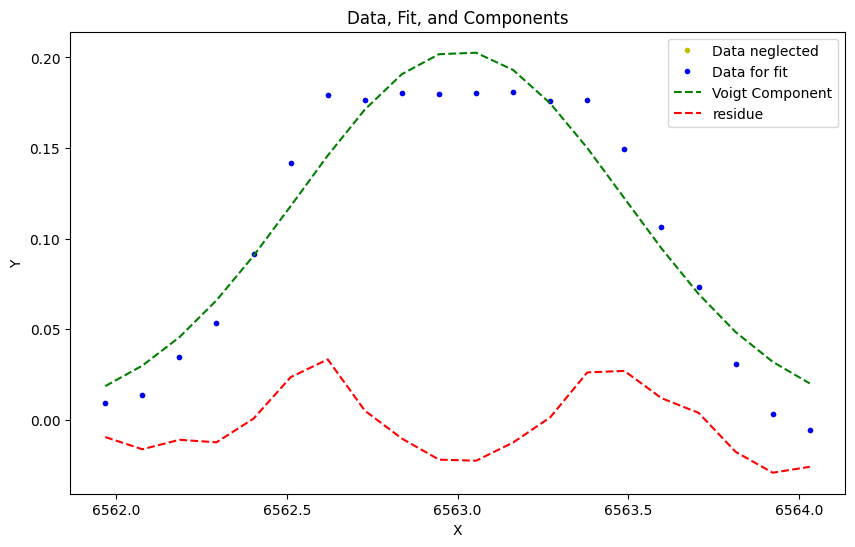

param_fit[-1] = (array([ 2.11934130e-01,  6.56300310e+03,  4.64785974e-01, -5.81605052e-04]), array([1.55389757e+01, 2.54212567e-02, 2.72691427e-02, 8.01969558e+03])). Here comes the plot:


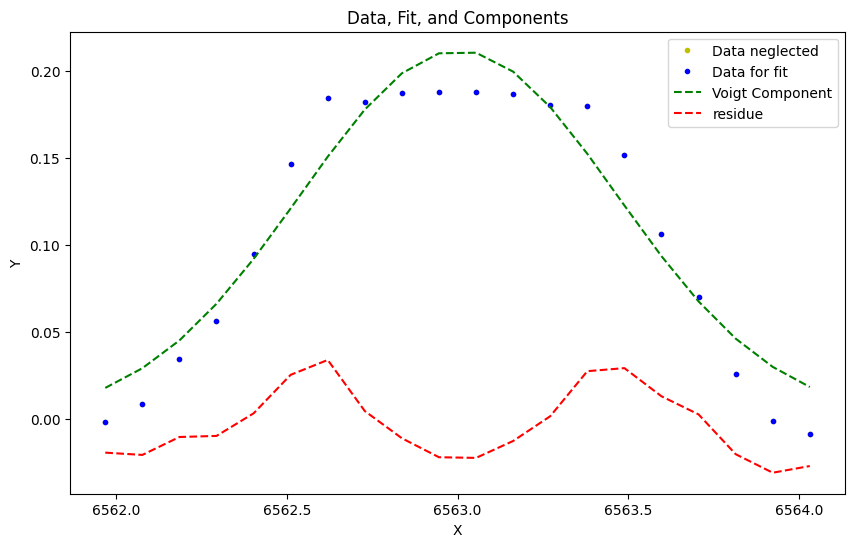

vlim = 0.033693696462282756


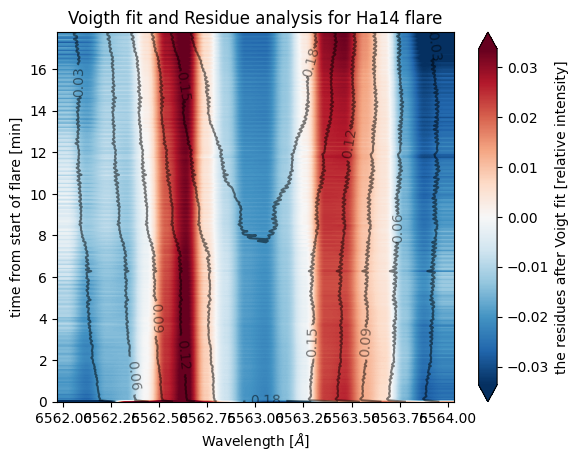

In [5]:
reload(un)
lines = ["Ha14"]
long_names = {"Ha14":r"H$\alpha$", "CaK17":r'Ca$IIK$', "CaII17":r'Ca$II 8542 \AA$'}

data = un.load_for_further_analysis(lines)
make_analysis('Ha14', data,[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
              plot_rate=40, offset=0.18, neglect_points=[])

the correction factor is 0.8739210853601194
param_fit[-1] = (array([5.19383269e-01, 6.56293385e+03, 5.52139533e-01, 5.86498986e-01]), array([0.01498984, 0.01788679, 0.11406702, 0.14743198])). Here comes the plot:


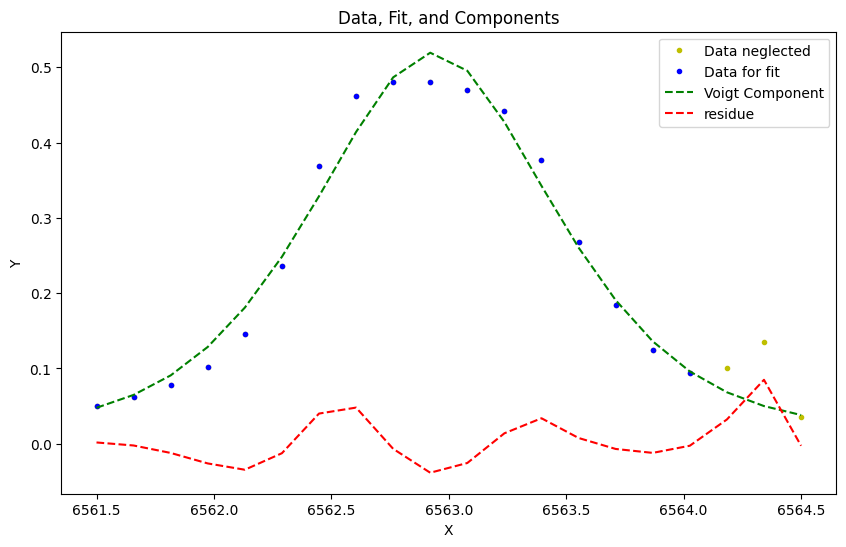

vlim = 0.09752174328070694


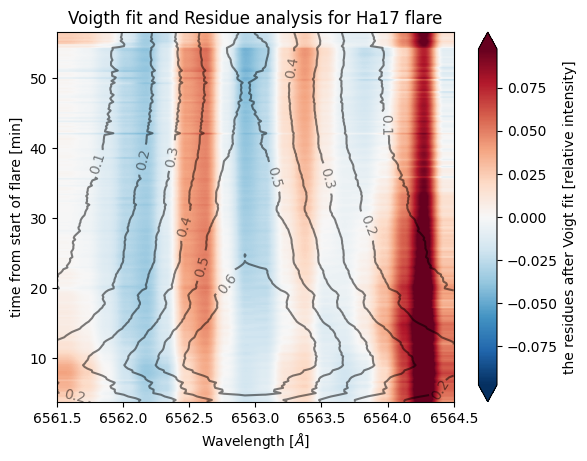

In [23]:
lines = ["Ha17", "CaK17", "CaII17"]
long_names = {"Ha17":r"H$\alpha$", "CaK17":r'Ca$IIK$', "CaII17":r'Ca$II 8542 \AA$'}


data0 = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
un2.disgard_cont_point("CaK17", data0)
data0.keys()
make_analysis('Ha17', data0,[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
              plot_rate=150, offset=0.17, neglect_points=[-3, -2, -1])

the correction factor is 0.739783479304269
param_fit[-1] = (array([ 1.03822793e+00,  8.54204057e+03, -2.89101803e-01, -3.47455548e-04]), array([2.43071487e+00, 6.30952627e-03, 6.80247002e-03, 2.83327370e+02])). Here comes the plot:


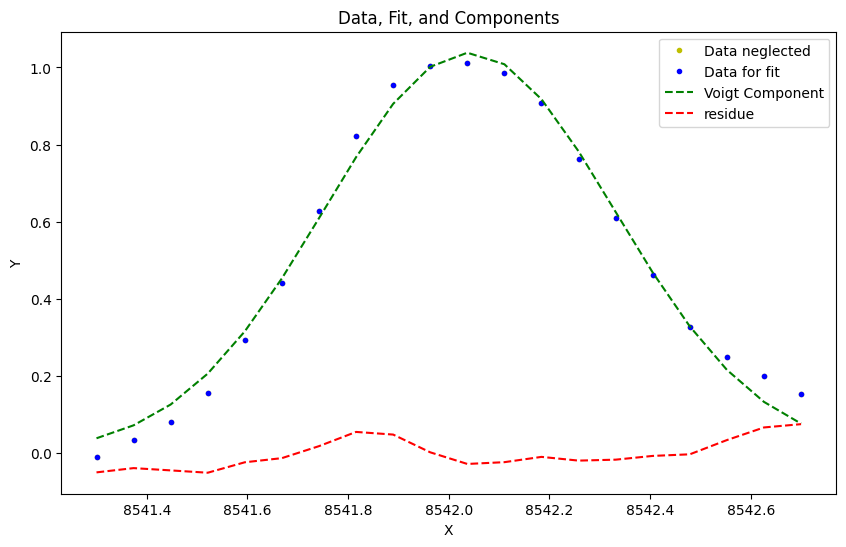

param_fit[-1] = (array([ 8.69865204e-01,  8.54203717e+03, -2.60116301e-01,  2.67864920e-05]), array([3.74082872e-02, 7.51277183e-03, 6.95418666e-03, 8.96184745e+01])). Here comes the plot:


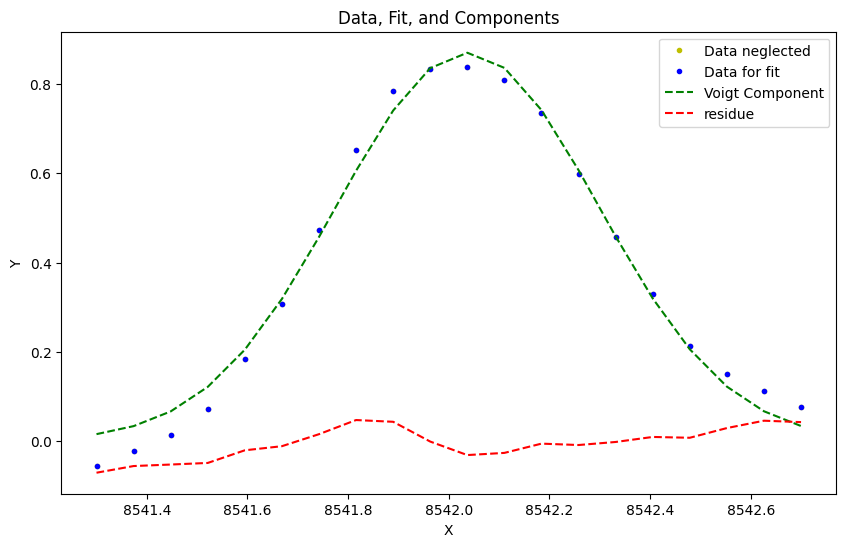

param_fit[-1] = (array([ 7.96332785e-01,  8.54202941e+03, -2.35235253e-01,  2.60127413e-04]), array([3.50157509e+00, 6.66036457e-03, 7.63708543e-03, 6.53391199e+02])). Here comes the plot:


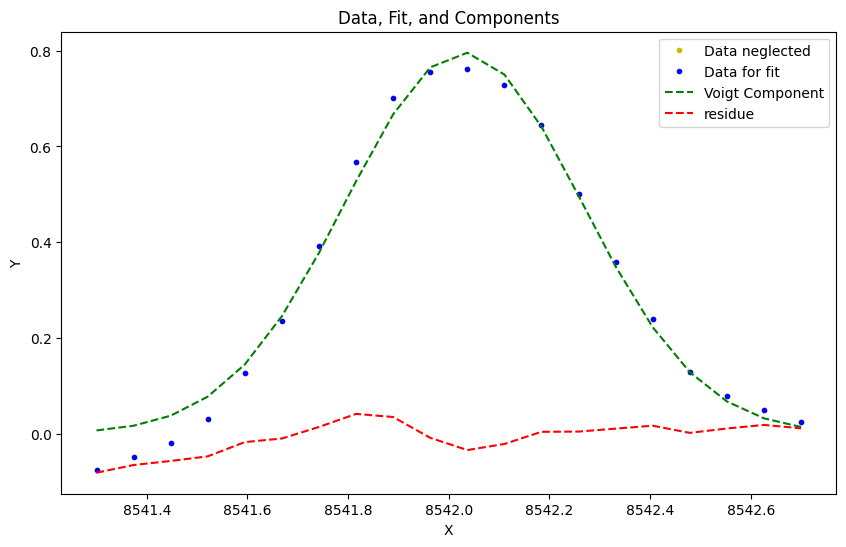

param_fit[-1] = (array([ 8.12400287e-01,  8.54202974e+03, -2.25859263e-01,  1.79001216e-04]), array([3.20108217e+00, 6.81071086e-03, 7.52140097e-03, 5.65620713e+02])). Here comes the plot:


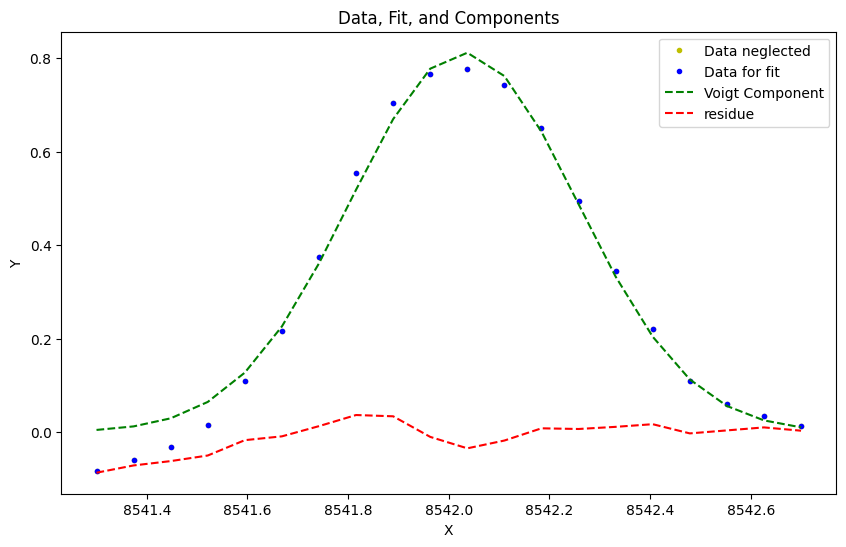

vlim = 0.07208041995374588


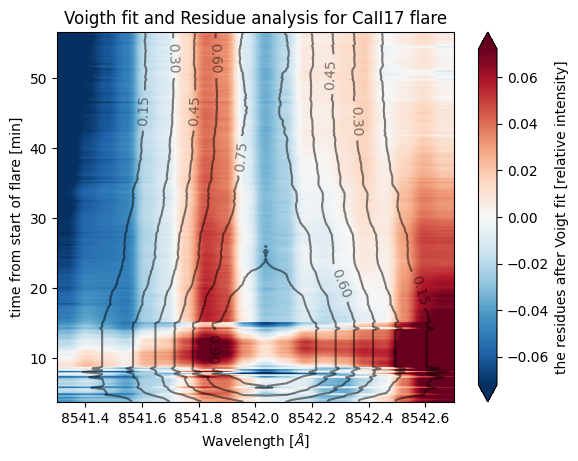

In [24]:
make_analysis('CaII17', data0,[1.5*0.74,  8.54203173e+03, -2.84932183e-01, -2.61301961e-04], plot_rate=50, fix_ind=[0,1, 2, 3])

the correction factor is 0.09195329098545146


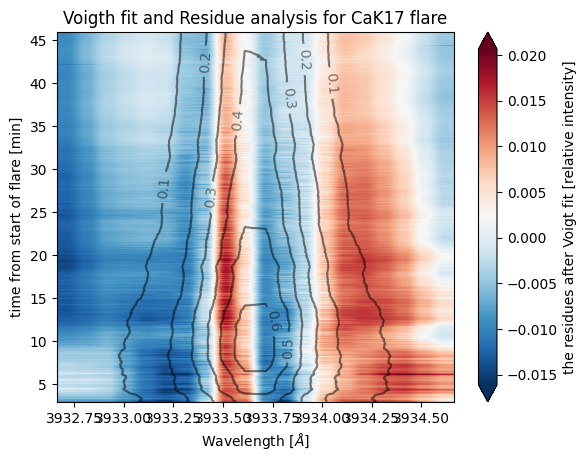

In [25]:
make_analysis('CaK17', data0,[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], plot_rate=550, offset=0.5*0.0919)

# X2.2 flare at 9 o'clock

In [26]:
lines = ["Ha17_9u"]
long_names = {"Ha17_9u":r"H$\alpha$"}

data = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
data.keys()

dict_keys(['FOV_Ha17_9u', 'quiet_sun_Ha17_9u', 'nessi_Ha17_9u', 'TIME_Ha17_9u'])

the correction factor is 0.7178257412287012
param_fit[-1] = (array([2.99531802e-01, 6.56298589e+03, 4.53963623e-01, 9.87766264e-04]), array([1.22642456e+01, 1.62940732e-02, 1.49300537e-02, 4.27108517e+03])). Here comes the plot:


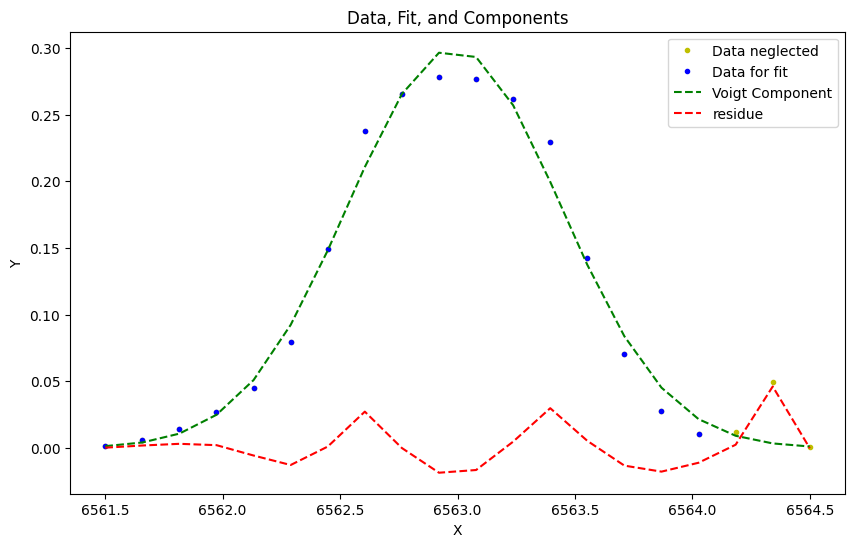

vlim = 0.04048390632693185


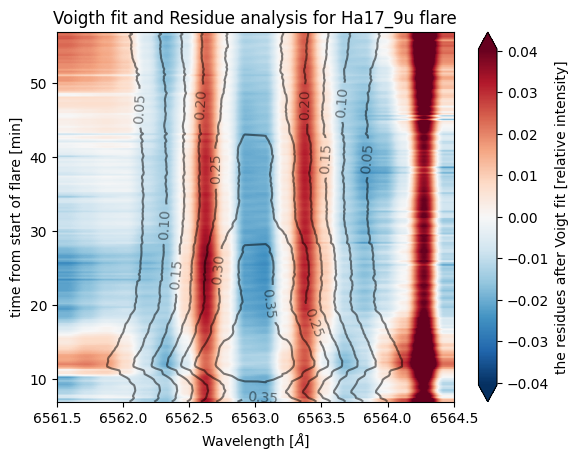

In [27]:
initial_guesses = {'Ha':[5.55265545e-01*0.71, 6.56293638e+03, 5.29257897e-01*0.71, 4.96399919e-01/0.71]}

make_full_analysis(data, lines, init_guesses=initial_guesses, offsets=[0.2*0.71], 
                   plot_rate=150, list_neglect_points=[[-3, -2, -1]])


# the C1.3 flare 2013

dict_keys(['FOV_Ha13', 'quiet_sun_Ha13', 'nessi_Ha13', 'TIME_Ha13'])
the correction factor is 0.8821712151803175
param_fit[-1] = (array([1.45161547e-01, 6.56308291e+03, 3.89725328e-01, 2.17434016e-04]), array([6.38100018e-01, 1.94258612e-02, 2.39335405e-02, 1.54560429e+03])). Here comes the plot:


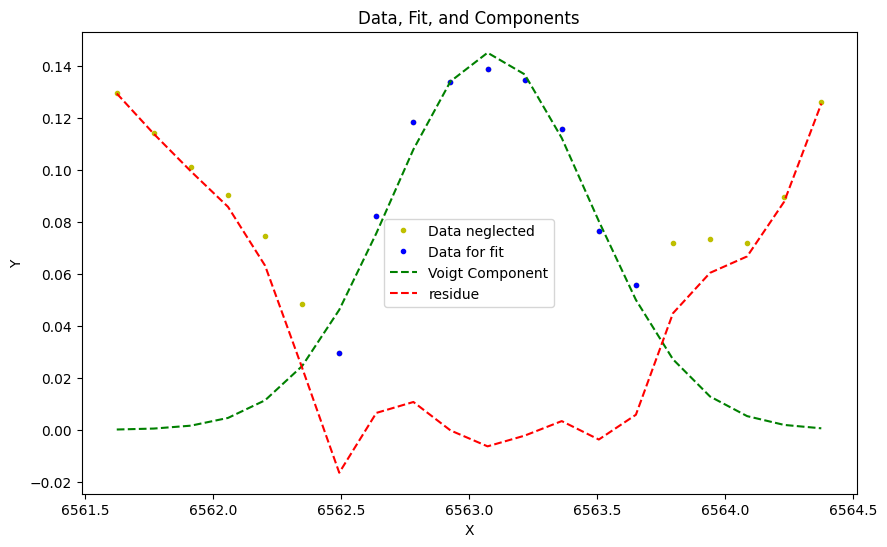

param_fit[-1] = (array([ 1.34462099e-01,  6.56308568e+03,  3.79638720e-01, -8.98299042e-05]), array([2.20909346e+00, 2.49473620e-02, 2.50896717e-02, 4.93179794e+03])). Here comes the plot:


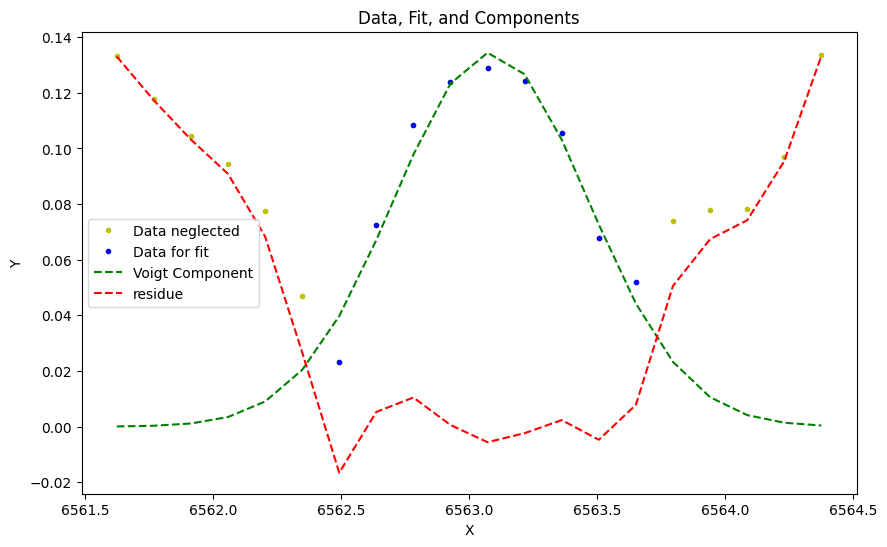

vlim = 0.13312250503103246


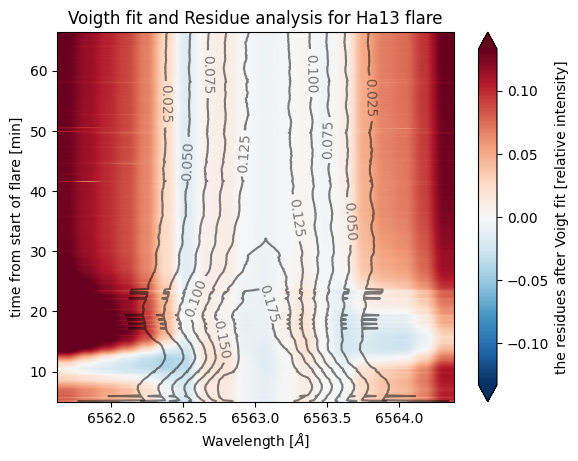

In [28]:
reload(un)
lines = ["Ha13"]
long_names = {"Ha13":r"H$\alpha$ 2013"}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2013-06-30/")
print(data.keys())


initial_guesses = {'Ha':[5.55265545e-01*0.88, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01]}
lnp=[[0,1,2,3,4,5,-5,-4,-3, -2, -1]]
make_full_analysis(data, lines, offsets=[0.09*0.88], plot_rate=250, init_guesses=initial_guesses, list_neglect_points=lnp)

# C2.2 flare 2019

dict_keys(['FOV_CaIR19', 'quiet_sun_CaIR19', 'nessi_CaIR19', 'TIME_CaIR19', 'FOV_Fe6173_2019', 'quiet_sun_Fe6173_2019', 'nessi_Fe6173_2019', 'TIME_Fe6173_2019', 'FOV_CaK19', 'quiet_sun_CaK19', 'nessi_CaK19', 'TIME_CaK19'])
the correction factor is 0.6934060535332651
vlim = 0.013513784076394891


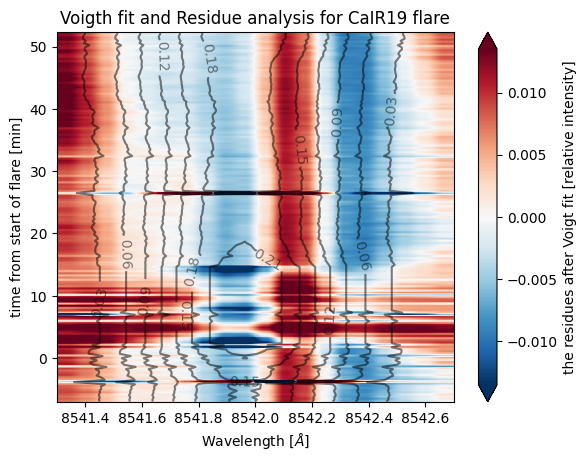

the correction factor is 0.7912546190700971


KeyboardInterrupt: 

In [29]:
c1 = 0.6934060535332651
c2 = 0.7912546190700971
c3 = 0.12995492392730582

reload(un)
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
offsets = [0.05*c1, 0.01, 0.05*c3]
long_names = {"Fe6173_2019":r"Fe 6173", "CaK19":r'Ca$IIK$', "CaIR19":r'Ca$II 8542 \AA$'}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2019-05-06/")
un2.disgard_cont_point("CaK19", data)

print(data.keys())

initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5*c3, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[ 2.40164464e-01,  8.54196662e+03, -2.52162356e-01,  -1.92634373e-04],
                   "Fe6173":[4.13090273e-02*c2, 6.1728106e+03, -1.55441909e-03, 4.25981451e-02]}
lnp=[[], [0,1,2,3,-9, -8, -7,-6,-5,-4,-3, -2, -1], []]

make_full_analysis(data, lines, offsets=offsets, init_guesses=initial_guesses, plot_rate=250, list_neglect_points=lnp, fix_ind={"CaIR":[0,1,2,3]})

# C5.6

dict_keys(['FOV_CaIR15', 'quiet_sun_CaIR15', 'nessi_CaIR15', 'TIME_CaIR15', 'FOV_Ha15', 'quiet_sun_Ha15', 'nessi_Ha15', 'TIME_Ha15'])
the correction factor is 0.9533701253460637
param_fit[-1] = (array([ 1.12344096e-01,  8.54442519e+03, -2.43918173e-01,  2.90952268e-05]), array([1.05733734e-01, 3.39017512e-02, 6.12086357e-02, 1.00791310e+03])). Here comes the plot:


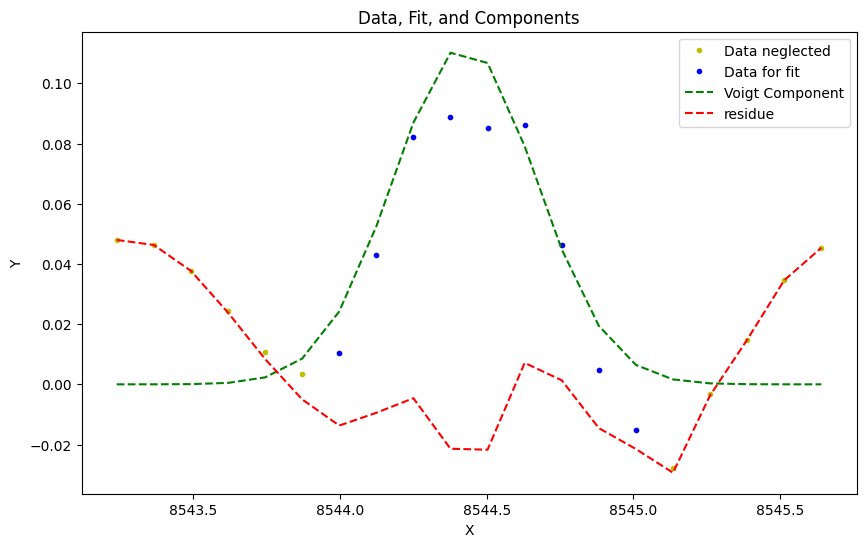

param_fit[-1] = (array([ 7.65252794e-02,  8.54439587e+03, -3.00417270e-01,  7.83467388e-05]), array([2.61031254e-01, 3.63304222e-02, 4.19681506e-02, 2.00551014e+03])). Here comes the plot:


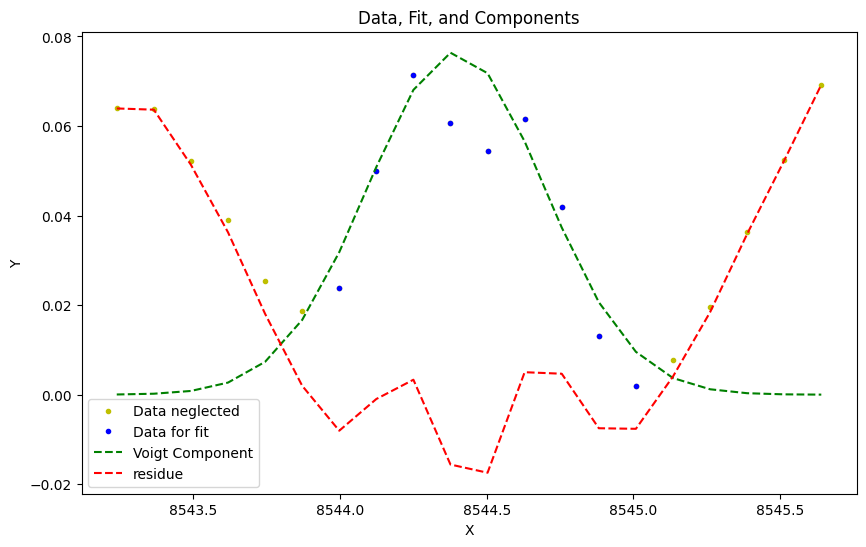

vlim = 0.08033454971636259


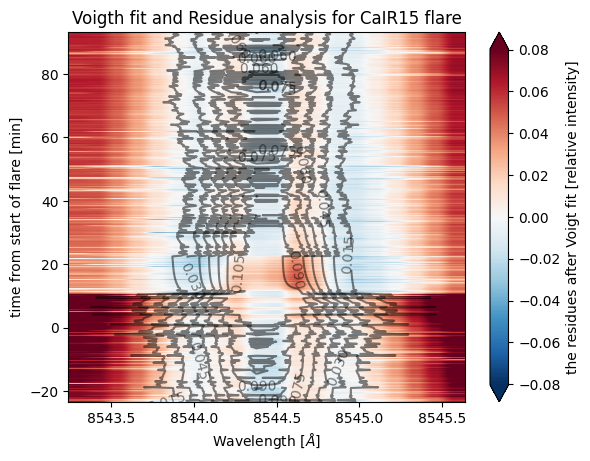

the correction factor is 0.8661149805010958
param_fit[-1] = (array([6.49976953e-02, 6.56458298e+03, 3.04311945e-01, 2.77457016e-04]), array([1.40051906e+00, 1.94231056e-02, 1.80434039e-02, 3.60320701e+03])). Here comes the plot:


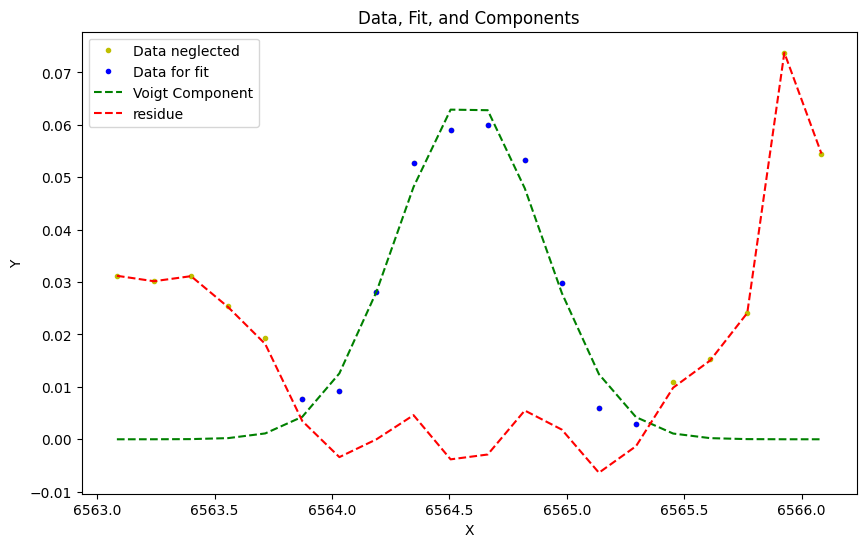

param_fit[-1] = (array([ 5.18624865e-02,  6.56452127e+03, -9.34973851e-06,  4.82019504e-01]), array([inf, inf, inf, inf])). Here comes the plot:


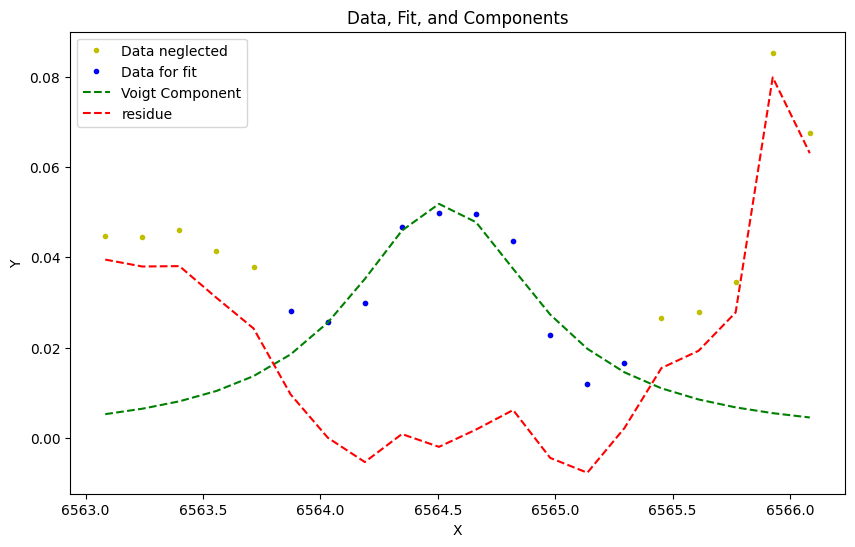

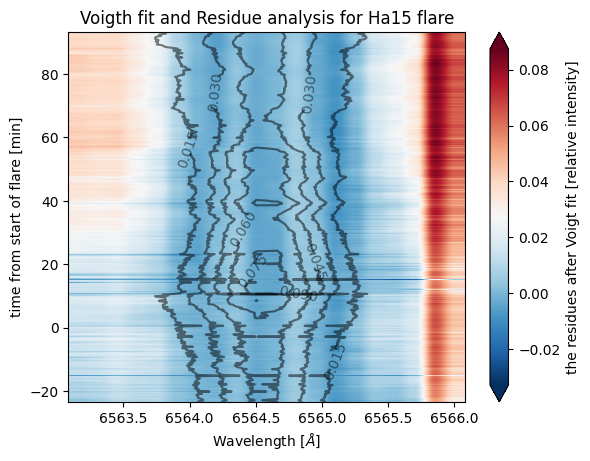

In [ ]:
reload(un)
lines = ["CaIR15", "Ha15"]
offsets = [0.012*0.95, 0.023, 0.05]

data = un.load_for_further_analysis(lines, full_path = un.full_path("15"))

print(data.keys())

initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[0.12,  8544.4, -2.62017731e-01,  4.46885934e-04],
                   "Fe6173":[4.13090273e-02, 6.1728106e+03, -1.55441909e-03, 4.25981451e-02]}
lnp=[[0,1,2,3,4,5, -5,-4,-3,-2,-1], [0,1,2,3,4,-5,-4,-3,-2,-1], []]

make_full_analysis(data, lines, offsets=offsets, init_guesses=initial_guesses, plot_rate=250, list_neglect_points=lnp)

